# Preliminary analysis

In this notebook, we will explore the data and point out things to look out for, such as the confounds and masks to use.

## Goals
* Perform confound regression
* Masking the data using brainmask files


In [1]:
from packages import *
%matplotlib inline

In [2]:
from collections import Counter
import sklearn
from _1_file_acquisition import get_subject_images
from nilearn.image.image import mean_img

Importing Jupyter notebook from _1_file_acquisition.ipynb


Using the functions from the previous notebook, we can load in the images.

In [3]:
images = get_subject_images(1, DATA_DIR, fmri_prep_reqs=['preproc', 'brainmask', 'confounds'])

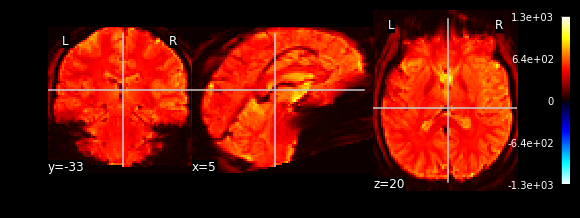

In [4]:
PLOTS['stat_map'](mean_img(images['fmriprep'][1][1]['preproc']), images['fmriprep'][1][1]['brainmask'])

### Masking
Most of the voxels in the scan will not be of use to us. To filter them, we will build masks and apply them by doing element-wise matrix multiplications. For this example we will use the brainmask from the same session to discard voxels that are outside the brain. Later on, we will build specific masks for brain regions, gray matter and etc.

In [7]:
timeseries_bold = images['fmriprep'][1][1]['preproc'].get_fdata()
brainmask = images['fmriprep'][1][1]['brainmask'].get_fdata()
timeseries_bold = timeseries_bold * np.expand_dims(brainmask, -1)

We can see the effect of the mask by plotting the mean image again.

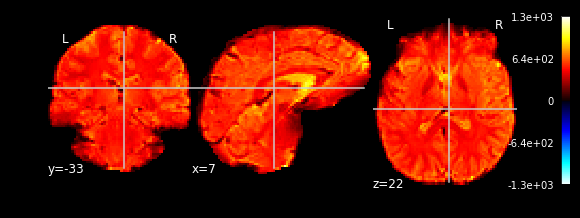

In [9]:
PLOTS['stat_map'](mean_img(make_img(timeseries_bold, images['fmriprep'][1][1]['preproc'].affine)), images['fmriprep'][1][1]['brainmask'])

Next, we will flatten the three-dimensional array for each time-point for the next part.

In [13]:
timeseries_bold = np.moveaxis(timeseries_bold, -1, 0)
timeseries_bold = timeseries_bold.reshape(194, np.product(timeseries_bold.shape[1:]))
timeseries_bold.shape

(194, 454968)

### Confounds

The fmriprep scans contain confounds tables where movement and rotation confounds are provided. We can use the values for these confounds to decorrelate the timeseries form the effects of these confounds.

/home/kaan/anaconda3/envs/brain-decoding_3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


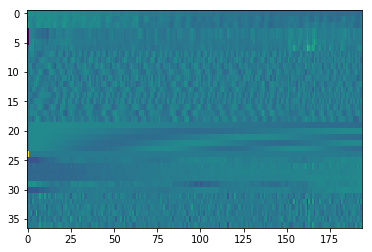

In [10]:
confounds = images['fmriprep'][1][1]['confounds'].replace(np.nan,0)
# add temporal derivatives of motion estimates
motionvars=['X', 'Y', 'Z', 'RotX', 'RotY', 'RotZ']
for v in motionvars:
    confounds['%s_deriv'%v]=0
    confounds['%s_deriv'%v][1:]=confounds[v].iloc[1:].values -confounds[v].iloc[:-1].values

plt.imshow(sklearn.preprocessing.scale(confounds).T,aspect='auto',
           cmap='viridis',interpolation='nearest')

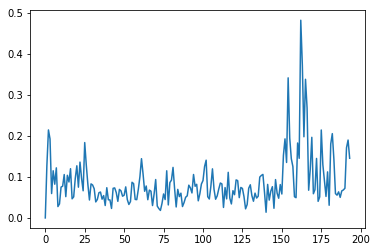

In [11]:
plt.plot(confounds.FramewiseDisplacement)

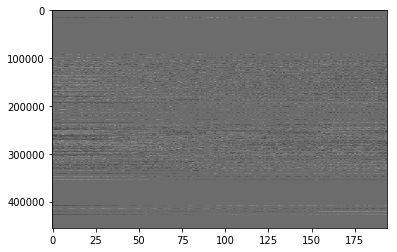

In [14]:
plt.imshow(sklearn.preprocessing.scale(timeseries_bold).T,aspect='auto',
           cmap='gray',interpolation='nearest')

In [32]:
# confounds with GSR
confounds_to_include = ['CSF', 'WhiteMatter', 'GlobalSignal', 'stdDVARS',
                        'FramewiseDisplacement', 'tCompCor00', 'tCompCor01',
                        'tCompCor02', 'tCompCor03', 'tCompCor04', 'tCompCor05', 
                        'aCompCor00','aCompCor01', 'aCompCor02', 'aCompCor03', 
                        'aCompCor04', 'aCompCor05',
                        'Cosine00', 'Cosine01', 'Cosine02', 'Cosine03', 'Cosine04', 'X', 
                        'Y', 'Z', 'RotX', 'RotY', 'RotZ',
                        'X_deriv', 'Y_deriv', 'Z_deriv', 'RotX_deriv', 'RotY_deriv',
                        'RotZ_deriv']

confounds_gsr=confounds.loc[:, confounds_to_include]

In [53]:
lr=sklearn.linear_model.LinearRegression(fit_intercept=False)

lr.fit(confounds_gsr.values, timeseries_bold)
bolddata_reg_gsr = timeseries_bold - lr.predict(confounds_gsr)

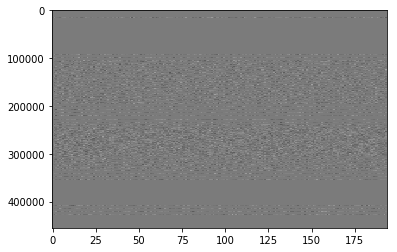

In [54]:
plt.imshow(sklearn.preprocessing.scale(bolddata_reg_gsr).T,aspect='auto',
           cmap='gray',interpolation='nearest')

In [60]:
bolddata_reg_gsr /= np.mean(bolddata_reg_gsr)

In [61]:
bolddata_reg_gsr = np.moveaxis(bolddata_reg_gsr.reshape(194, *images['fmriprep'][1][1]['preproc'].shape[:-1]), 0, -1)